## 分析加法,乘法運算時底層硬體電路受到白雜訊 (SNR) 干擾發生的錯誤

* AER (Arithmetic Error Rate): 1bit 發生加錯或減錯的機率 (like BER)
* CER (Carry Error Rate): Carry(進位) 受到影響而發生錯誤的機率
* RER (Register Error Rate): 整個資料的發生錯誤的機率 (like BLER)

#### 加法: 以全加器 --> Ripple-Carry-Adder 模擬

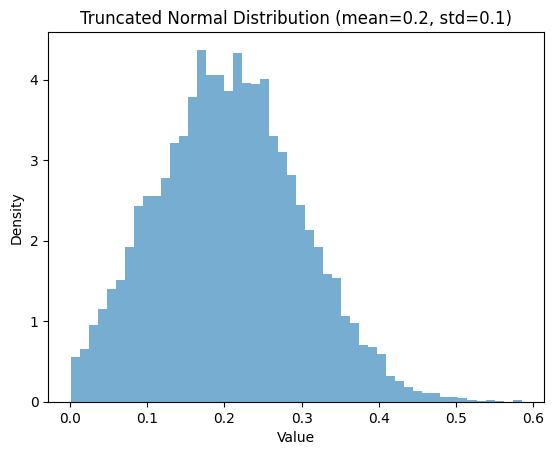

實際標準差: 0.09267001960457757
0.12341515452324235


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randn, randint
import random
import scipy
from scipy.stats import truncnorm
import math
from numpy import sqrt

a, b = 0, 1  # 範圍限制在 0 ~ 1
mean = 0.2   # 平均值
std = 0.1    # 標准差
data = truncnorm.rvs((a - mean) / std, (b - mean) / std, loc=mean, scale=std, size=10000)

### 輸出直方圖
plt.hist(data, bins=50, density=True, alpha=0.6)
plt.title(f"Truncated Normal Distribution (mean={mean}, std={std})")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

### 計算實際標準差
print("實際標準差:", np.std(data))   
print(np.random.normal(0, 0.2))

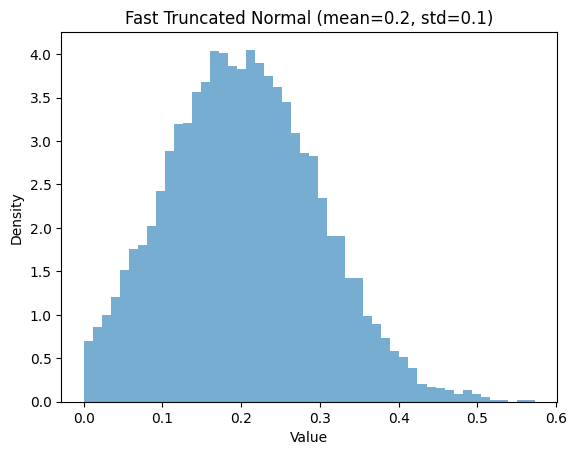

實際標準差: 0.09496561934676995


In [21]:
def fast_truncated_normal(mean, std, low, high, size):
    result = []
    while len(result) < size:
        samples = np.random.normal(loc=mean, scale=std, size=size)
        accepted = samples[(samples >= low) & (samples <= high)]
        result.extend(accepted)
    return np.array(result[:size])  # 裁切到精確大小

a, b = 0, 1     # 截斷範圍
mean = 0.2
std = 0.1
size = 10000

data = fast_truncated_normal(mean, std, a, b, size)

# 繪圖
plt.hist(data, bins=50, density=True, alpha=0.6)
plt.title(f"Fast Truncated Normal (mean={mean}, std={std})")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

# 標準差
print("實際標準差:", np.std(data))


In [22]:
def truncated_normal_sample(mean, std, low, high):
    while True:
        x = np.random.normal(mean, std)
        if low <= x <= high:
            return x
        
sample = truncated_normal_sample(mean=0.2, std=0.1, low=0, high=1)
print("Sample:", sample)

Sample: 0.3208553916450554


#### Uncode example:

In [23]:
### 50bits + 50bits
Range_Max_number = 1125899906842623
bits = math.floor(math.log2(Range_Max_number)) + 1

def simulate_adder_noise(A, B, sigma, threshold=0.42):
    """
    模擬 Ripple-Carry-Adder,計算 A + B
    - A, B: bits位數值
    - sigma: 高斯白雜訊的標準差
    - threshold: 當雜訊超過此值，翻轉該位元
    回傳值: 最終結果 (包含可能的溢位)
    """
    carry_in = 0
    
    result_bits = []
    
    for i in range(bits):
        a_bit = (A >> i) & 1
        b_bit = (B >> i) & 1
        
        #### 所有1-bit加法器邏輯閘, 以及模擬雜訊 ####
        XOR_AB = a_bit ^ b_bit
        ### 引入高斯白雜訊
        noise_XOR_AB = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        # 如果雜訊絕對值超過 threshold，翻轉該位
        if abs(noise_XOR_AB) > threshold:
            XOR_AB = XOR_AB ^ 1            #翻轉 XOR_AB
        
        sum_out = XOR_AB ^ carry_in
        noise_sum = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_sum) > threshold:
            sum_out = sum_out ^ 1           #翻轉 sum_out
            
        AND_AB = a_bit & b_bit
        noise_AND_AB = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_AND_AB) > threshold:
            AND_AB = AND_AB ^ 1             #翻轉 AND_AB
        
        AND_Cin = XOR_AB & carry_in
        noise_AND_Cin = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_AND_Cin) > threshold:
            AND_Cin = AND_Cin ^ 1           #翻轉 AND_Cin
            
        carry_out = AND_AB | AND_Cin
        noise_carry = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_carry) > threshold:
            carry_out = carry_out ^ 1       #翻轉 carry_out
        
        result_bits.append(sum_out)
        carry_in = carry_out                #傳遞到下一個位元
    
    # 第5位 (溢位)
    result_bits.append(carry_in)
        
    # 將 result_bits (list) 組合成整數
    final_result = 0
    for i, bit_val in enumerate(result_bits):
        final_result |= (bit_val << i)
    
    return final_result

def noise_simulation(trials=100000, sigma=0.2, threshold=0.42):
    
    error_count = 0
    for _ in range(trials):
        A = random.randint(0, Range_Max_number)     # 隨機整數 A
        B = random.randint(0, Range_Max_number)     # 隨機整數 B
        correct_result = A + B                      # 正確答案
        result = simulate_adder_noise(A, B, sigma, threshold)
        if result != correct_result:
            error_count += 1
    
    uncode_error_rate = error_count / trials
    return uncode_error_rate

if __name__ == "__main__":
    # 參數設定
    uncode_list = []
    trials = 200000                             # 模擬次數
    EbNodB_range = range(12,23)
    itr = len(EbNodB_range)
    threshold = 0.42                             # 當雜訊超過此值時翻轉
    
    for n in range (0, itr): 
        EbNodB = EbNodB_range[n]   
        EbNo=10.0**(EbNodB/10.0)
        noise_std = 1/sqrt(2*EbNo)
        uncode_error_rate = noise_simulation(trials=trials, sigma=noise_std, threshold=threshold)
        uncode_list.append(uncode_error_rate)
        print(f"SNR={EbNodB}, Noise_std={noise_std}, Error Rate={uncode_error_rate:.5f}")

SNR=12, Noise_std=0.17761719292909026, Error Rate=1.00000
SNR=13, Noise_std=0.15830148982673414, Error Rate=1.00000
SNR=14, Noise_std=0.1410863513160464, Error Rate=1.00000
SNR=15, Noise_std=0.12574334296829354, Error Rate=0.99995
SNR=16, Noise_std=0.11206887238456492, Error Rate=0.99667
SNR=17, Noise_std=0.09988148764833452, Error Rate=0.95976
SNR=18, Noise_std=0.08901946956877224, Error Rate=0.78943
SNR=19, Noise_std=0.07933868576533668, Error Rate=0.47300
SNR=20, Noise_std=0.07071067811865475, Error Rate=0.19340
SNR=21, Noise_std=0.06302095820932435, Error Rate=0.05507
SNR=22, Noise_std=0.05616748812614789, Error Rate=0.01041


In [24]:
print(uncode_list)

[1.0, 1.0, 1.0, 0.99995, 0.996665, 0.959765, 0.789425, 0.473, 0.193405, 0.055075, 0.01041]


#### Single AWE ANcode Decoder(A=131)

In [27]:

def A131_AN_decoder(residue):
    msg = {  
        1: +2**0,
        2: +2**1,
        4: +2**2,
        8: +2**3,
        16: +2**4,
        32: +2**5,
        64: +2**6,
        128: +2**7,
        125: +2**8,
        119: +2**9,
        107: +2**10,
        83: +2**11,
        35: +2**12,
        70: +2**13,
        9: +2**14,
        18: +2**15,
        36: +2**16,
        72: +2**17,
        13: +2**18,
        26: +2**19,
        52: +2**20,
        104: +2**21,
        77: +2**22,
        23: +2**23,
        46: +2**24,
        92: +2**25,
        53: +2**26,
        106: +2**27,
        81: +2**28,
        31: +2**29,
        62: +2**30,
        124: +2**31,
        117: +2**32,
        103: +2**33,
        75: +2**34,
        19: +2**35,
        38: +2**36,
        76: +2**37,
        21: +2**38,
        42: +2**39,
        84: +2**40,
        37: +2**41,
        74: +2**42,
        17: +2**43,
        34: +2**44,
        68: +2**45,
        5: +2**46,
        10: +2**47,
        20: +2**48,
        40: +2**49,
        80: +2**50,
        29: +2**51,
        58: +2**52,
        116: +2**53,
        101: +2**54,
        71: +2**55,
        11: +2**56,
        22: +2**57,
        44: +2**58,
        88: +2**59,
        45: +2**60,
        90: +2**61,
        49: +2**62,
        98: +2**63,
        65: +2**64,
        130: -2**0,
        129: -2**1,
        127: -2**2,
        123: -2**3,
        115: -2**4,
        99: -2**5,
        67: -2**6,
        3: -2**7,
        6: -2**8,
        12: -2**9,
        24: -2**10,
        48: -2**11,
        96: -2**12,
        61: -2**13,
        122: -2**14,
        113: -2**15,
        95: -2**16,
        59: -2**17,
        118: -2**18,
        105: -2**19,
        79: -2**20,
        27: -2**21,
        54: -2**22,
        108: -2**23,
        85: -2**24,
        39: -2**25,
        78: -2**26,
        25: -2**27,
        50: -2**28,
        100: -2**29,
        69: -2**30,
        7: -2**31,
        14: -2**32,
        28: -2**33,
        56: -2**34,
        112: -2**35,
        93: -2**36,
        55: -2**37,
        110: -2**38,
        89: -2**39,
        47: -2**40,
        94: -2**41,
        57: -2**42,
        114: -2**43,
        97: -2**44,
        63: -2**45,
        126: -2**46,
        121: -2**47,
        111: -2**48,
        91: -2**49,
        51: -2**50,
        102: -2**51,
        73: -2**52,
        15: -2**53,
        30: -2**54,
        60: -2**55,
        120: -2**56,
        109: -2**57,
        87: -2**58,
        43: -2**59,
        86: -2**60,
        41: -2**61,
        82: -2**62,
        33: -2**63,
        66: -2**64,
        0: 0,
    }
    return msg.get(residue, 0)  # 預設為 0，避免 None



def Barret_q_131(x):
    q = (int(x) * 4400463758041400) >> 59       ## (2^59)//131後, 右移59次         
    r = x - q * 131
    if r < 131:
        return (r,q)
    else:
        return (r - 131, q + 1)

#### Conventional SEC_ANcode:

In [28]:
SEC_A = 131
Range_Max_number = 1125899906842623
SEC_Range_Max_number = 1125899906842623 * SEC_A
SEC_A_bits = math.floor(math.log2(SEC_Range_Max_number)) + 1
print(SEC_A_bits)

58


In [29]:
def simulate_adder_noise(A, B, sigma, threshold=0.42):
    """
    模擬 Ripple-Carry-Adder,計算 A + B
    - A, B: bits位數值
    - sigma: 高斯白雜訊的標準差
    - threshold: 當雜訊超過此值，翻轉該位元
    回傳值: 最終結果 (包含可能的溢位)
    """
    carry_in = 0
    
    result_bits = []
    
    for i in range(SEC_A_bits):
        a_bit = (A >> i) & 1
        b_bit = (B >> i) & 1
        
        #### 所有1-bit加法器邏輯閘, 以及模擬雜訊 ####
        XOR_AB = a_bit ^ b_bit
        ### 引入高斯白雜訊
        noise_XOR_AB = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        # 如果雜訊絕對值超過 threshold，翻轉該位
        if abs(noise_XOR_AB) > threshold:
            XOR_AB = XOR_AB ^ 1            #翻轉 XOR_AB
        
        sum_out = XOR_AB ^ carry_in
        noise_sum = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_sum) > threshold:
            sum_out = sum_out ^ 1           #翻轉 sum_out
            
        AND_AB = a_bit & b_bit
        noise_AND_AB = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_AND_AB) > threshold:
            AND_AB = AND_AB ^ 1             #翻轉 AND_AB
        
        AND_Cin = XOR_AB & carry_in
        noise_AND_Cin = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_AND_Cin) > threshold:
            AND_Cin = AND_Cin ^ 1           #翻轉 AND_Cin
            
        carry_out = AND_AB | AND_Cin
        noise_carry = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_carry) > threshold:
            carry_out = carry_out ^ 1       #翻轉 carry_out
        
        result_bits.append(sum_out)
        carry_in = carry_out                #傳遞到下一個位元
    
    # 第5位 (溢位)
    result_bits.append(carry_in)
        
    # 將 result_bits (list) 組合成整數
    final_result = 0
    for i, bit_val in enumerate(result_bits):
        final_result |= (bit_val << i)
    
    return final_result

def noise_simulation(trials=100000, sigma=0.2, threshold=0.42):
        
    error_count = 0
    for _ in range(trials):
        A = random.randint(0, Range_Max_number)  # 隨機整數 A
        B = random.randint(0, Range_Max_number)  # 隨機整數 B
        correct_result = A + B                   
        SEC_AN_A = A * SEC_A
        SEC_AN_B = B * SEC_A
        result_withA = simulate_adder_noise(SEC_AN_A, SEC_AN_B, sigma, threshold)
        result_dividebyA = result_withA // SEC_A
        if result_dividebyA != correct_result:
            r,q = Barret_q_131(result_withA)
            RAW_DATA = int(result_withA) - int(A131_AN_decoder(r))
            corrected_r,corrected_value = Barret_q_131(RAW_DATA)
            if corrected_value != correct_result:
                error_count += 1
    
    SEC_error_rate = error_count / trials
    return SEC_error_rate

if __name__ == "__main__":
    # 參數設定
    SEC_AN_list = []
    trials = 200000                             # 模擬次數
    EbNodB_range = range(12,23)
    itr = len(EbNodB_range)
    threshold = 0.42                             # 當雜訊超過此值時翻轉
    
    for n in range (0, itr): 
        EbNodB = EbNodB_range[n]   
        EbNo=10.0**(EbNodB/10.0)
        noise_std = 1/sqrt(2*EbNo)
        SEC_error_rate = noise_simulation(trials=trials, sigma=noise_std, threshold=threshold)
        SEC_AN_list.append(SEC_error_rate)
        print(f"SNR={EbNodB}, Noise_std={noise_std}, Error Rate={SEC_error_rate:.6f}")

SNR=12, Noise_std=0.17761719292909026, Error Rate=1.000000
SNR=13, Noise_std=0.15830148982673414, Error Rate=1.000000
SNR=14, Noise_std=0.1410863513160464, Error Rate=0.999995
SNR=15, Noise_std=0.12574334296829354, Error Rate=0.999585
SNR=16, Noise_std=0.11206887238456492, Error Rate=0.988215
SNR=17, Noise_std=0.09988148764833452, Error Rate=0.870725
SNR=18, Noise_std=0.08901946956877224, Error Rate=0.518185
SNR=19, Noise_std=0.07933868576533668, Error Rate=0.161180
SNR=20, Noise_std=0.07071067811865475, Error Rate=0.024635
SNR=21, Noise_std=0.06302095820932435, Error Rate=0.001845
SNR=22, Noise_std=0.05616748812614789, Error Rate=0.000065


In [30]:
print(SEC_AN_list)

[1.0, 1.0, 0.999995, 0.999585, 0.988215, 0.870725, 0.518185, 0.16118, 0.024635, 0.001845, 6.5e-05]


### 使用查找表更正: DEC_ANcode, A = 50861
* Function Definition

In [31]:
import math
import numpy as np

def decimal_to_binary(decimal_number):
    if decimal_number == 0:
        return "0"
    # 處理正數：直接轉換
    if decimal_number > 0:
        return bin(decimal_number)[2:]  # 移除 "0b" 前綴
       # 處理負數：自動計算所需位元數（2's complement）
    abs_value = abs(decimal_number)
    bits = abs_value.bit_length() + 1  # 負數多一個符號位元
    two_complement_value = (1 << bits) + decimal_number
    
    return bin(two_complement_value)[2:]  # 移除 "0b" 前綴

def bits_needed(number):
    if number < 0:
        raise ValueError("2's complement is not available")  # 如果輸入負數，拋出錯誤
    if number == 0:
        return 1  # 0 需要 1 個位元
    
    # 計算位元數
    bits = math.floor(math.log2(number)) + 1
    return bits

def bits_range(bits, signed=False):     ## 可選擇設定 有號數 或 無號數
    if bits <= 0:
        return "位元數必須為正整數！"
    
    if signed:
        # 二補數範圍: -2^(bits-1) 到 2^(bits-1)-1
        min_value = -(2**(bits - 1))
        max_value = 2**(bits - 1) - 1
    else:
        # 無符號範圍: 0 到 2^bits - 1
        min_value = 0
        max_value = 2**bits - 1

    return min_value, max_value

## 把重複的 AWE 去除
def remove_duplicates(input_list):
    unique_list = []
    for number in input_list:
        if number not in unique_list:
            unique_list.append(number)
    return sorted(unique_list)

def custom_mod(a, b):
    if b == 0:
        return "錯誤：除數不能為零！"
    # 計算商和餘數，修正餘數計算邏輯
    quotient = a // b
    remainder = a - b * quotient
    # 修正負餘數的情況
    if remainder > 0 and a < 0:
        remainder -= abs(b)
        quotient += 1
    return remainder

def remainder_unique(input_list):
    # 使用集合判斷元素是否有重複
    return len(input_list) == len(set(input_list))


def create_mapping(source_list, address_map):
    """
    建立值到位址和位址到值的雙向映射。
    若 address_map 中某位址沒有對應值，則該位址的值為 0。
    
    參數:
    source_list (list): 原始資料列表。
    address_map (list): 位址映射列表。
    
    回傳:
    tuple: (值到位址的映射, 位址到值的映射)
    """
    # 初始化值到位址的映射
    value_to_address = {value: addr for value, addr in zip(source_list, address_map)}
    
    # 初始化位址到值的映射，未指定的位址預設為 0
    max_address = max(address_map)  # 確保涵蓋所有位址
    address_to_value = {addr: 0 for addr in range(max_address + 1)}  # 預設為 0
    for value, addr in zip(source_list, address_map):
        address_to_value[addr] = value  # 更新有指定值的位址

    return value_to_address, address_to_value
def decimal_to_binary(decimal_number):
    if decimal_number == 0:
        return "0"
    # 處理正數：直接轉換
    if decimal_number > 0:
        return bin(decimal_number)[2:]  # 移除 "0b" 前綴
       # 處理負數：自動計算所需位元數（2's complement）
    abs_value = abs(decimal_number)
    bits = abs_value.bit_length() + 1  # 負數多一個符號位元
    two_complement_value = (1 << bits) + decimal_number
    
    return bin(two_complement_value)[2:]  # 移除 "0b" 前綴

def bits_needed(number):
    if number < 0:
        raise ValueError("2's complement is not available")  # 如果輸入負數，拋出錯誤
    if number == 0:
        return 1  # 0 需要 1 個位元
    
    # 計算位元數
    bits = math.floor(math.log2(number)) + 1
    return bits

def bits_range(bits, signed=False):     ## 可選擇設定 有號數 或 無號數
    if bits <= 0:
        return "位元數必須為正整數！"
    
    if signed:
        # 二補數範圍: -2^(bits-1) 到 2^(bits-1)-1
        min_value = -(2**(bits - 1))
        max_value = 2**(bits - 1) - 1
    else:
        # 無符號範圍: 0 到 2^bits - 1
        min_value = 0
        max_value = 2**bits - 1

    return min_value, max_value

## 把重複的 AWE 去除
def remove_duplicates(input_list):
    unique_list = []
    for number in input_list:
        if number not in unique_list:
            unique_list.append(number)
    return sorted(unique_list)

def custom_mod(a, b):
    if b == 0:
        return "錯誤：除數不能為零！"
    # 計算商和餘數，修正餘數計算邏輯
    quotient = a // b
    remainder = a - b * quotient
    # 修正負餘數的情況
    if remainder > 0 and a < 0:
        remainder -= abs(b)
        quotient += 1
    return remainder

def remainder_unique(input_list):
    # 使用集合判斷元素是否有重複
    return len(input_list) == len(set(input_list))


In [32]:
### 輸入數值為data, ANcode的A為AN
### 乘完A後的數值為 input
data = 1125899906842623
AN =  50861    ## AN:50861, 只適用輸入為0 ~ 1125899906842623
input = data*AN
bits = bits_needed(input)

### 1-bit AWE:
AWE_1=[]
e1=0     ## 錯誤數量
e1_data=[]
for i in range(0, bits):
    AWE_1.insert(e1 , input + 2**i)
    e1_data.insert(e1, 2**i)
    e1 = e1 + 1
    AWE_1.insert(e1 , input - 2**i)
    e1_data.insert(e1, -2**i)
    e1 = e1 + 1
    
### 2-bit AWE:
AWE_2=[]
e2=0     ## 錯誤數量
p=0      ## 錯誤位置
e2_data=[]
for i in range(0, bits):
    for j in range(i+1, bits):
        AWE_2.insert(e2 , (input + 2**i + 2**j))
        e2_data.insert(e2 , (2**i + 2**j))        
        print(f"第 {e2} 筆錯誤資料: {AWE_2[e2]}")
        print(f"第 {e2} 筆算術錯誤: {e2_data[e2]}")
        e2 = e2 + 1
        AWE_2.insert(e2 , (input + 2**i - 2**j))
        e2_data.insert(e2 , (2**i - 2**j))        
        print(f"第 {e2} 筆錯誤資料: {AWE_2[e2]}")
        print(f"第 {e2} 筆算術錯誤: {e2_data[e2]}")
        e2 = e2 + 1
        AWE_2.insert(e2 , (input - 2**i + 2**j))
        e2_data.insert(e2 , (-2**i + 2**j))                
        print(f"第 {e2} 筆錯誤資料: {AWE_2[e2]}")
        print(f"第 {e2} 筆算術錯誤: {e2_data[e2]}")
        e2 = e2 + 1
        AWE_2.insert(e2 , (input - 2**i -2**j))
        e2_data.insert(e2 , (-2**i - 2**j))
        print(f"第 {e2} 筆錯誤資料: {AWE_2[e2]}")
        print(f"第 {e2} 筆算術錯誤: {e2_data[e2]}")
        e2 = e2 + 1
        p = p + 1
        
## 把list:AWE_1 和 list:AWE_2合併
AWE = AWE_1 + AWE_2
e_total = e1_data + e2_data
## 把重複的 AWE 去除
new_AWE = remove_duplicates(AWE)
new_e_total = remove_duplicates(e_total)
AWE_count = np.size(new_AWE)
e_count = np.size(new_e_total)

### 模AN, 使用一般mod函數和 Barret reduction 比較
remainder = []
for m in range(0,AWE_count):
    mod = new_AWE[m] % AN
    remainder.append(mod)

print("錯誤資料對AN取完模數:\n",remainder)

##############################################################
### Barret reduction ###
def Barret_q_50861(x):      
    q = (int(x) * 2901514964111527) >> 67        ## (2^67)//50861, 右移67次 
    r = x - q * 50861
    if r < 50861:
        return (r,q)
    else:
        return (r - 50861, q + 1)
    
Barret_remainder = []
for m in range(0,AWE_count):
    Barret_r,Barret_q = Barret_q_50861(new_AWE[m])
    Barret_remainder.append(Barret_r)
    
print("Barret reduction對錯誤資料取完模數:\n",Barret_remainder)
print("Barret reduction是否可以使用:", Barret_remainder == remainder)
#################################################################
print("所有餘數(一般mod函數)是否完全相異:", remainder_unique(remainder))
print("所有餘數(Barret reduction)是否完全相異:", remainder_unique(Barret_remainder))
print("所有的AWE:\n", new_e_total)
print(np.size(remainder))

### 建立錯誤映射表(LUT)
## Decoder
AWE_to_remainder, remainder_to_AWE = create_mapping(new_e_total, Barret_remainder)

## example
example_r1 = Barret_remainder[0]
example_r2 = Barret_remainder[1]
print(f"輸入餘數 {example_r1}, 對應算術錯誤: {remainder_to_AWE[example_r1]}")
print(f"輸入餘數 {example_r2}, 對應算術錯誤: {remainder_to_AWE[example_r2]}")

Raw_data1 = new_AWE[0]-remainder_to_AWE[example_r1]
Raw_data2 = new_AWE[1]-remainder_to_AWE[example_r2]
print(Raw_data1)
print(Raw_data2)
print("更正是否正確:", input == Raw_data1)

第 0 筆錯誤資料: 57264395161922648406
第 0 筆算術錯誤: 3
第 1 筆錯誤資料: 57264395161922648402
第 1 筆算術錯誤: -1
第 2 筆錯誤資料: 57264395161922648404
第 2 筆算術錯誤: 1
第 3 筆錯誤資料: 57264395161922648400
第 3 筆算術錯誤: -3
第 4 筆錯誤資料: 57264395161922648408
第 4 筆算術錯誤: 5
第 5 筆錯誤資料: 57264395161922648400
第 5 筆算術錯誤: -3
第 6 筆錯誤資料: 57264395161922648406
第 6 筆算術錯誤: 3
第 7 筆錯誤資料: 57264395161922648398
第 7 筆算術錯誤: -5
第 8 筆錯誤資料: 57264395161922648412
第 8 筆算術錯誤: 9
第 9 筆錯誤資料: 57264395161922648396
第 9 筆算術錯誤: -7
第 10 筆錯誤資料: 57264395161922648410
第 10 筆算術錯誤: 7
第 11 筆錯誤資料: 57264395161922648394
第 11 筆算術錯誤: -9
第 12 筆錯誤資料: 57264395161922648420
第 12 筆算術錯誤: 17
第 13 筆錯誤資料: 57264395161922648388
第 13 筆算術錯誤: -15
第 14 筆錯誤資料: 57264395161922648418
第 14 筆算術錯誤: 15
第 15 筆錯誤資料: 57264395161922648386
第 15 筆算術錯誤: -17
第 16 筆錯誤資料: 57264395161922648436
第 16 筆算術錯誤: 33
第 17 筆錯誤資料: 57264395161922648372
第 17 筆算術錯誤: -31
第 18 筆錯誤資料: 57264395161922648434
第 18 筆算術錯誤: 31
第 19 筆錯誤資料: 57264395161922648370
第 19 筆算術錯誤: -33
第 20 筆錯誤資料: 57264395161922648468
第 20 筆算術錯誤: 65
第 21 筆錯誤資料: 57

#### DEC_ANcode (LUT):

In [33]:
DEC_A = 50861
Range_Max_number = 1125899906842623
DEC_Range_Max_number = 1125899906842623 * DEC_A
DEC_A_bits = math.floor(math.log2(DEC_Range_Max_number)) + 1
print(DEC_A_bits)

66


In [38]:
def simulate_adder_noise(A, B, sigma, threshold=0.42):
    """
    模擬 Ripple-Carry-Adder,計算 A + B
    - A, B: bits位數值
    - sigma: 高斯白雜訊的標準差
    - threshold: 當雜訊超過此值，翻轉該位元
    回傳值: 最終結果 (包含可能的溢位)
    """
    carry_in = 0
    
    result_bits = []
    
    for i in range(DEC_A_bits):
        a_bit = (A >> i) & 1
        b_bit = (B >> i) & 1
        
        #### 所有1-bit加法器邏輯閘, 以及模擬雜訊 ####
        XOR_AB = a_bit ^ b_bit
        ### 引入高斯白雜訊
        noise_XOR_AB = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        # 如果雜訊絕對值超過 threshold，翻轉該位
        if abs(noise_XOR_AB) > threshold:
            XOR_AB = XOR_AB ^ 1            #翻轉 XOR_AB
        
        sum_out = XOR_AB ^ carry_in
        noise_sum = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_sum) > threshold:
            sum_out = sum_out ^ 1           #翻轉 sum_out
            
        AND_AB = a_bit & b_bit
        noise_AND_AB = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_AND_AB) > threshold:
            AND_AB = AND_AB ^ 1             #翻轉 AND_AB
        
        AND_Cin = XOR_AB & carry_in
        noise_AND_Cin = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_AND_Cin) > threshold:
            AND_Cin = AND_Cin ^ 1           #翻轉 AND_Cin
            
        carry_out = AND_AB | AND_Cin
        noise_carry = truncated_normal_sample(mean=0.2, std=sigma, low=0, high=1)
        if abs(noise_carry) > threshold:
            carry_out = carry_out ^ 1       #翻轉 carry_out
        
        result_bits.append(sum_out)
        carry_in = carry_out                #傳遞到下一個位元
    
    # 第5位 (溢位)
    result_bits.append(carry_in)
        
    # 將 result_bits (list) 組合成整數
    final_result = 0
    for i, bit_val in enumerate(result_bits):
        final_result |= (bit_val << i)
    
    return final_result

def noise_simulation(trials=100000, sigma=0.2, threshold=0.42):
        
    error_count = 0
    for _ in range(trials):
        A = random.randint(0, Range_Max_number)  # 隨機整數 A
        B = random.randint(0, Range_Max_number)  # 隨機整數 B
        correct_result = A + B                   # 正確答案
        DEC_AN_A = A * DEC_A
        DEC_AN_B = B * DEC_A
        result_withA = simulate_adder_noise(DEC_AN_A, DEC_AN_B, sigma, threshold)
        result_dividebyA = result_withA // DEC_A
        if result_dividebyA != correct_result:
            r,q = Barret_q_50861(result_withA)
            ### using LUT to recover it 
            RAW_DATA = int(result_withA) - int(remainder_to_AWE[r])
            corrected_r, corrected_value = Barret_q_50861(RAW_DATA)
            if corrected_value != correct_result:
                error_count += 1
    
    DEC_error_rate = error_count / trials
    return DEC_error_rate

if __name__ == "__main__":
    # 參數設定
    DEC_AN_list = []
    trials = 250000                            # 模擬次數
    EbNodB_range = range(12,23)
    itr = len(EbNodB_range)
    threshold = 0.42                             # 當雜訊超過此值時翻轉
    
    for n in range (0, itr): 
        EbNodB = EbNodB_range[n]   
        EbNo=10.0**(EbNodB/10.0)
        noise_std = 1/sqrt(2*EbNo)
        DEC_error_rate = noise_simulation(trials=trials, sigma=noise_std, threshold=threshold)
        DEC_AN_list.append(DEC_error_rate)
        print(f"SNR={EbNodB}, Noise_std={noise_std}, Error Rate={DEC_error_rate:.6f}")

SNR=12, Noise_std=0.17761719292909026, Error Rate=1.000000
SNR=13, Noise_std=0.15830148982673414, Error Rate=1.000000
SNR=14, Noise_std=0.1410863513160464, Error Rate=1.000000
SNR=15, Noise_std=0.12574334296829354, Error Rate=0.999320
SNR=16, Noise_std=0.11206887238456492, Error Rate=0.975396
SNR=17, Noise_std=0.09988148764833452, Error Rate=0.764520
SNR=18, Noise_std=0.08901946956877224, Error Rate=0.316496
SNR=19, Noise_std=0.07933868576533668, Error Rate=0.053624
SNR=20, Noise_std=0.07071067811865475, Error Rate=0.005140
SNR=21, Noise_std=0.06302095820932435, Error Rate=0.000664
SNR=22, Noise_std=0.05616748812614789, Error Rate=0.000104


In [39]:
print(DEC_AN_list)

[1.0, 1.0, 1.0, 0.99932, 0.975396, 0.76452, 0.316496, 0.053624, 0.00514, 0.000664, 0.000104]


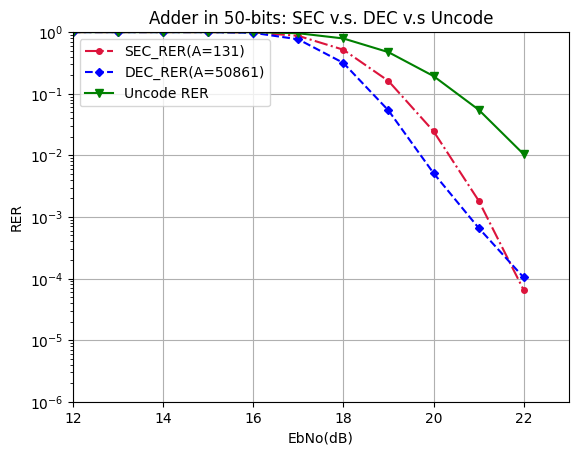

In [40]:
import matplotlib.pyplot as plt

SEC_RER = plt.plot(EbNodB_range, SEC_AN_list,marker='o',linestyle='-.',color='#DC143C',markersize=4,label="SEC_RER(A=131)")
DEC_RER = plt.plot(EbNodB_range, DEC_AN_list,marker='D', linestyle='--',color='#0000FF',markersize=4,label="DEC_RER(A=50861)")
Uncode_RER=plt.plot(EbNodB_range, uncode_list,color='#008000',marker='v', linestyle='-',markersize=6,label="Uncode RER")


plt.legend()
plt.axis([12, 23, 1e-6, 1])
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('EbNo(dB)')
plt.ylabel('RER')
plt.grid(True)
plt.title('Adder in 50-bits: SEC v.s. DEC v.s Uncode')
plt.savefig("Adder in 50bits SEC vs DEC vs Uncode(21dB)")
plt.show()

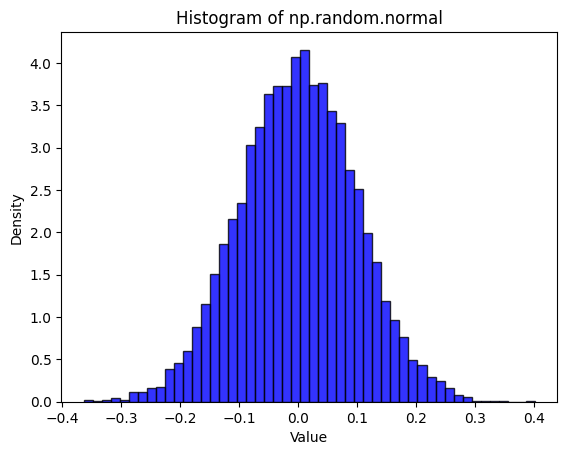

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# 生成常態分佈數據
data = np.random.normal(0, 0.1, 10000)  # 生成10000個point

# 繪製直方圖
plt.hist(data, bins=50, density=True, alpha=0.8, color='blue', edgecolor='black')


plt.title('Histogram of np.random.normal')
plt.xlabel('Value')
plt.ylabel('Density')


plt.show()